In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mtp
mtp.rcParams["pdf.fonttype"] = 42

import warnings
warnings.filterwarnings('ignore')

In [2]:
tcgaDf = pd.read_csv("C:/Data/Lab/Carter_Lab/aneuploidy_data/TCGA_TP_allgene.csv")
hnsc = tcgaDf[tcgaDf.disease == "HNSC"]
#CD3_marker = ["CD3D","CD3E","CD3G"]
Bcell_marker = ["CD19","MS4A1"]

#hnsc["CD3"] = sp.stats.gmean(np.log2(1+hnsc[CD3_marker]),axis=1)
hnsc["Bcell"]  = sp.stats.gmean(np.log2(1+hnsc[Bcell_marker]),axis=1)

In [3]:
def PFSsurvival(Df,gene,diseaseName,time = 3000, save = False,fdir = None):
    """Progression free survival analysis
    @Df: the data frame of input, should contain gene cateogorical variable
    @gene: categorical varialbe of "HIGH" and "LOW" as seperated groups for analysis
    @time: the limitation of time, default is to 3000
    @diseaseName: the name of the disease, usually is a tumor type
    """
    f_dir = "C:/Data/Lab/Zanetti_Lab/HNSC/"
    
    import matplotlib as mtp
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()
    from lifelines.statistics import logrank_test
    mtp.rcParams['pdf.fonttype'] = 42
    
    pfs=pd.read_csv(f_dir + "PFSfile.csv")
    Df=pd.merge(Df,pfs[['patient_id','PFS','PFS.time']],on='patient_id')
    Df.dropna(subset=['PFS.time','PFS'],inplace=True)
    Df = Df[Df["PFS.time"] < time]
    Df.drop_duplicates(inplace=True)
    
    groups = Df[gene]
    high = (groups == 'HIGH')
    low = (groups == 'LOW')

    T = Df['PFS.time'][low]
    T = T.astype(np.int)
    C = Df['PFS'][low]*1
    C = C.astype(np.int)

    T2 = Df['PFS.time'][high]
    T2 = T2.astype(np.int)
    C2 = Df['PFS'][high]*1
    C2 = C2.astype(np.int)

    fig,ax = plt.subplots(figsize = (6,6),sharex=True,sharey=True)
    result_H = kmf.fit(T,C,label= str(gene)+ " low = "+ str(len(Df[Df[gene] == 'LOW'])))
    kmf.plot(ci_show=False,ax =ax )
    ax.scatter(x = 'timeline', y = str(gene)+" low = "+ str(len(Df[Df[gene] == 'LOW'])),
        data = result_H.survival_function_.reset_index(),marker = "|", c = 'blue',
              s = 500)

    result_L = kmf.fit(T2,C2,label = str(gene)+' high = '+ str(len(Df[Df[gene] == 'HIGH'])))
    kmf.plot(ci_show=False,ax =ax )

    ax.scatter(x = 'timeline', y = str(gene)+' high = '+ str(len(Df[Df[gene] == 'HIGH'])),
        data = result_L.survival_function_.reset_index(),marker = "|", c = 'orange',
              s = 500)
    plt.title(diseaseName+' survival plot signature')
    plt.ylim([-.1,1.1])
    if save:
        #f_dir = "C:/Data/Lab/Zanetti_Lab/Figures/"
        plt.savefig(fdir,bbox_inches = "tight")
    result = logrank_test(T.astype(np.int), T2.astype(np.int), C.astype(np.int), C2.astype(np.int), alpha=0.95)
    print(result.p_value)

# Supplementary Figure 3

0.9541182904096374


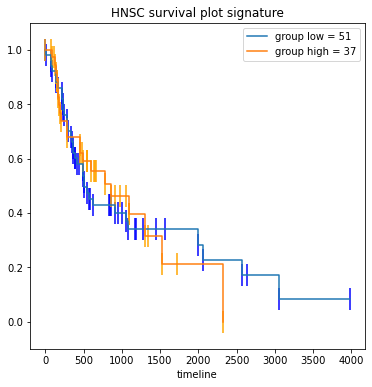

In [4]:
def plot_tert_low(df = hnsc):
    
    f_dir = "C:/Data/Lab/Zanetti_Lab/HNSC/"
    
    df = df[Bcell_marker + ["TERT","patient_id"]]
    df = df.groupby("patient_id")[["TERT"] + Bcell_marker].mean()
    
    b_exp = sp.stats.gmean(np.log2(1+df[Bcell_marker]),axis=1)
    b_cat = pd.cut(x = b_exp,bins = [-np.inf,np.quantile(b_exp,q=.3),np.quantile(b_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    tert_exp = np.log2(1+df["TERT"]).values
    tert_cat = pd.cut(x = tert_exp, bins = [-np.inf,np.quantile(tert_exp,q=.3),np.quantile(tert_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    low_ids = df[(b_cat == "LOW") & (tert_cat == "LOW")].index.tolist()
    high_ids = df[(b_cat == "HIGH") & (tert_cat == "LOW")].index.tolist()
    
    df = df.loc[high_ids + low_ids]
    df["group"] = [ "HIGH" if x in set(high_ids) else "LOW" for x in df.index.tolist()]
    
    stage_dict = {"Stage I":1,"Stage II":2, "Stage III":3, "Stage IV":4}
    stage = pd.read_csv(f_dir + "stageinfo.csv",header = None)
    stage.columns = ["patient_id","stage"]
    df = pd.merge(df, stage, on = "patient_id").drop_duplicates()
    
    PFSsurvival(df,"group","HNSC",time=10000,save=True,fdir = "C:/Data/Lab/Zanetti_Lab/HNSC/PNASNEXUS/bcell_tertlow.pdf")
    
plot_tert_low(df = hnsc)

# Supplementary Figure 4

0.024856637539517286
0.06453908974885895


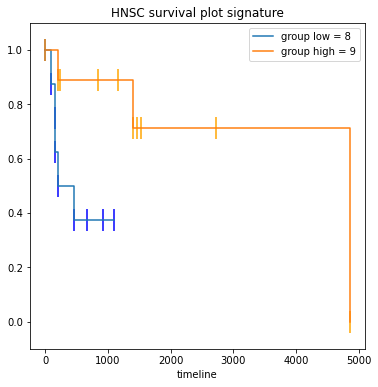

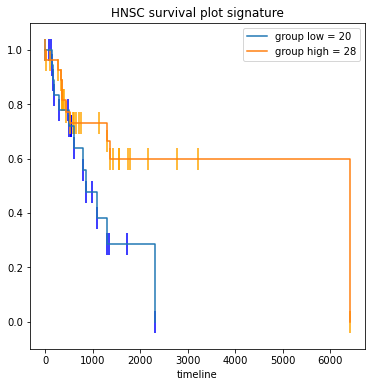

In [5]:
def plot_survival_by_stage_combined(df = hnsc):
    
    f_dir = "C:/Data/Lab/Zanetti_Lab/HNSC/"
    
    df = df[Bcell_marker + ["TERT","patient_id"]]
    df = df.groupby("patient_id")[["TERT"] + Bcell_marker].mean()
    
    b_exp = sp.stats.gmean(np.log2(1+df[Bcell_marker]),axis=1)
    b_cat = pd.cut(x = b_exp,bins = [-np.inf,np.quantile(b_exp,q=.3),np.quantile(b_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    tert_exp = np.log2(1+df["TERT"]).values
    tert_cat = pd.cut(x = tert_exp, bins = [-np.inf,np.quantile(tert_exp,q=.3),np.quantile(tert_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    low_ids = df[(b_cat == "HIGH") & (tert_cat == "LOW")].index.tolist()
    high_ids = df[(b_cat == "HIGH") & (tert_cat == "HIGH")].index.tolist()
    
    df = df.loc[high_ids + low_ids]
    df["group"] = [ "HIGH" if x in set(high_ids) else "LOW" for x in df.index.tolist()]
    
    stage_dict = {"Stage I":1,"Stage II":2, "Stage III":3, "Stage IV":4}
    stage = pd.read_csv(f_dir + "stageinfo.csv",header = None)
    stage.columns = ["patient_id","stage"]
    df = pd.merge(df, stage, on = "patient_id").drop_duplicates()
    
    combine_stage_dict = {"Stage I":"L","Stage II":"L", "Stage III":"H", "Stage IV":"H"}
    df["combined_stage"] = [ combine_stage_dict[x] if x in combine_stage_dict else np.nan for x in df["stage"]]
    for stage in ["L","H"]:
        tmp = df[df["combined_stage"] == stage]
        PFSsurvival(tmp,"group","HNSC",time=10000,save=True,fdir = "C:/Data/Lab/Zanetti_Lab/HNSC/PNASNEXUS/bhiterthi_stage_"+stage +".pdf")
    
plot_survival_by_stage_combined(df = hnsc)

# Supplementary Figure 8

In [6]:
single_cell = pd.read_csv("C:/Data/Lab/Zanetti_Lab/single_cell_hnsc/GSE103322_HNSCC_all_data.txt",sep = "\t")
single_cell_assignment = pd.read_excel("C:/Data/Lab/Zanetti_Lab/single_cell_hnsc/HNSCC_tumor_assignment.xlsx",header = None)
single_cell_assignment[0] = [ x[1:-1] for x in single_cell_assignment[0]]
id_maps = dict(zip(single_cell_assignment[0].tolist(),single_cell_assignment[1].tolist()))
single_cell_genes = single_cell["Unnamed: 0"].tolist()
single_cell_genes = single_cell_genes[5:]
single_cell_genes = [ x[1:-1] for x in single_cell_genes]
cell_type_mapping = dict(zip(single_cell.columns.tolist()[1:],single_cell.iloc[4].tolist()[1:]))

In [7]:
tmp = single_cell.set_index("Unnamed: 0").loc["'TERT'"].sort_values(ascending = False)[:30]
tmp = pd.DataFrame(tmp)
tmp.columns = ["TERT"]
tmp["celltype"] = [ cell_type_mapping[x] if x in cell_type_mapping else "cancer cell" for x in tmp.index.tolist()]
tmp["celltype"] = tmp["celltype"].replace(0.0,"cancer")
tmp["ids"] = [id_maps[x] for x in tmp.index.tolist()]

<AxesSubplot:xlabel='celltype', ylabel='TERT'>

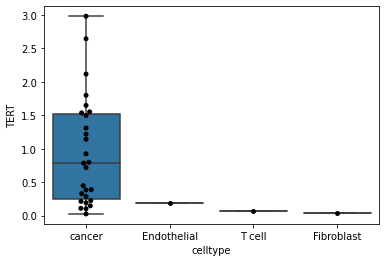

In [8]:
sns.swarmplot(x = "celltype",y = "TERT",data = tmp,color = "k")
sns.boxplot(x = "celltype",y = "TERT",data = tmp)